In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
     pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import hashlib
import random
from tqdm import tqdm
from PIL import Image, ImageEnhance
from torchvision import transforms
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model


2025-05-12 05:57:22.086177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747029442.282650      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747029442.339836      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

train_df = pd.read_csv("/kaggle/input/sports-image-classification/dataset/train.csv")

print("Train shape:", train_df.shape)

print(train_df.head())


Train shape: (8227, 2)
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


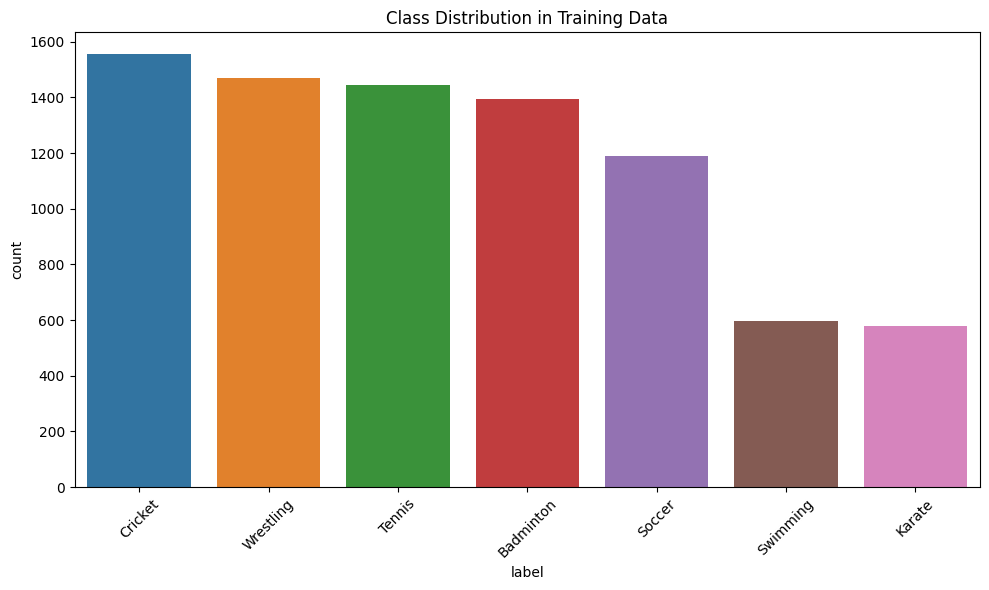

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


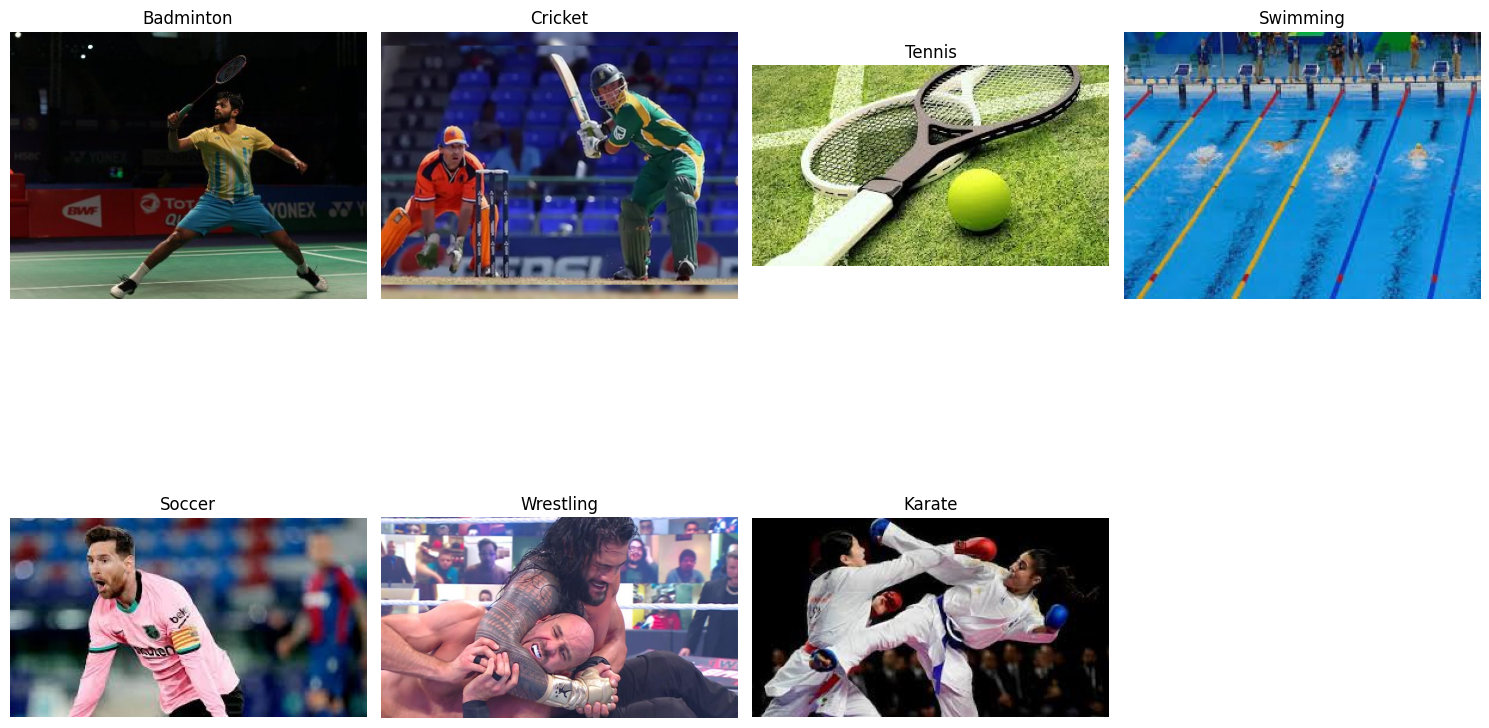

In [5]:

IMG_DIR = "/kaggle/input/sports-image-classification/dataset/train"
classes = train_df['label'].unique()
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    # Get one image from each class
    sample_img_id = train_df[train_df['label'] == cls]['image_ID'].iloc[0]
    img_path = os.path.join(IMG_DIR, sample_img_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Duplicates in image_id
duplicate_ids = train_df[train_df.duplicated("image_ID")]
print("Duplicate image_id entries:")
print(duplicate_ids)

# Remove duplicates if needed
train_df.drop_duplicates(subset="image_ID", inplace=True)
train_df.reset_index(drop=True, inplace=True)


Duplicate image_id entries:
Empty DataFrame
Columns: [image_ID, label]
Index: []


Found 2 exact duplicate image pairs.


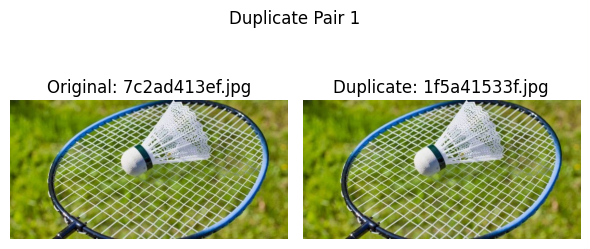

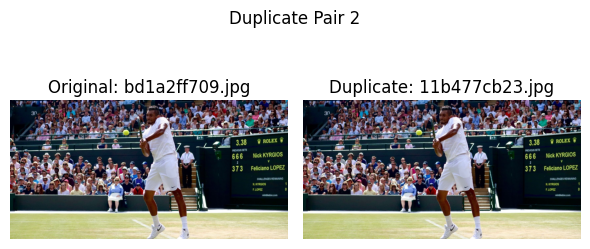

In [7]:

def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicate_image_pairs = []  # Store (original, duplicate) pairs

for i, row in train_df.iterrows():
    img_path = IMG_DIR + '/' + row['image_ID']
    try:
        img_hash = get_image_hash(img_path)
        if img_hash in image_hashes:
            duplicate_image_pairs.append((image_hashes[img_hash], row['image_ID']))
        else:
            image_hashes[img_hash] = row['image_ID']
    except:
        continue

print(f"Found {len(duplicate_image_pairs)} exact duplicate image pairs.")

# 🔍 Plot first few duplicate pairs
num_to_show = min(5, len(duplicate_image_pairs))
for i in range(num_to_show):
    img1_id, img2_id = duplicate_image_pairs[i]
    img1 = cv2.imread(IMG_DIR + '/' + img1_id)
    img2 = cv2.imread(IMG_DIR + '/' + img2_id)

    # Convert from BGR to RGB for matplotlib
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,3))
    plt.suptitle(f'Duplicate Pair {i+1}')
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f'Original: {img1_id}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f'Duplicate: {img2_id}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [8]:
# Step 1: Extract duplicate image IDs only (second in each pair)
duplicate_ids_to_remove = [dup for orig, dup in duplicate_image_pairs]

# Step 2: Remove them from the DataFrame
print(f"Removing {len(duplicate_ids_to_remove)} duplicate entries...")

train_df_cleaned = train_df[~train_df['image_ID'].isin(duplicate_ids_to_remove)].copy()
train_df_cleaned.reset_index(drop=True, inplace=True)

print(f"Dataset reduced from {len(train_df)} to {len(train_df_cleaned)} images.")

train_df_cleaned.to_csv("train_cleaned.csv", index=False)



Removing 2 duplicate entries...
Dataset reduced from 8227 to 8225 images.


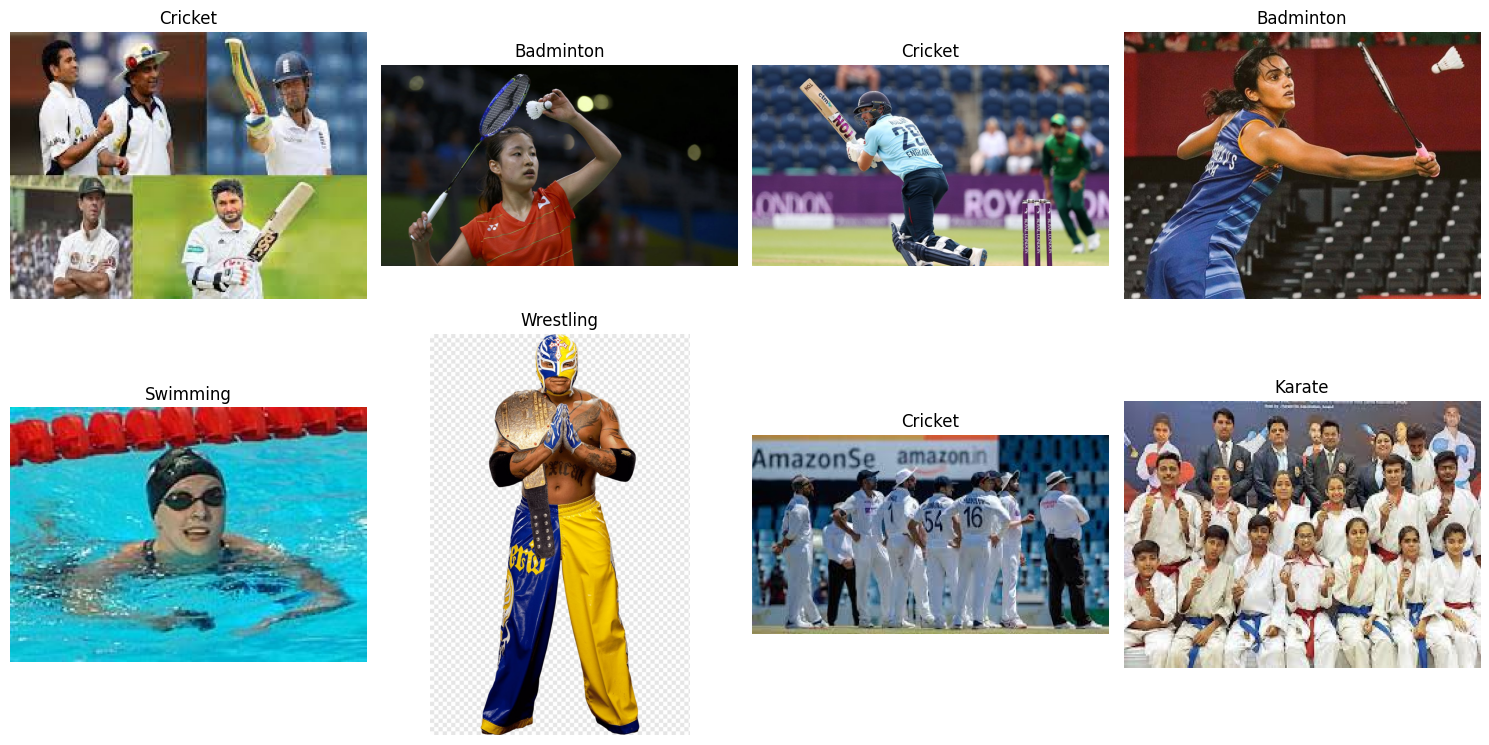

In [9]:

sample_rows = train_df.sample(8)
plt.figure(figsize=(15, 8))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_path = os.path.join(IMG_DIR, row['image_ID'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()


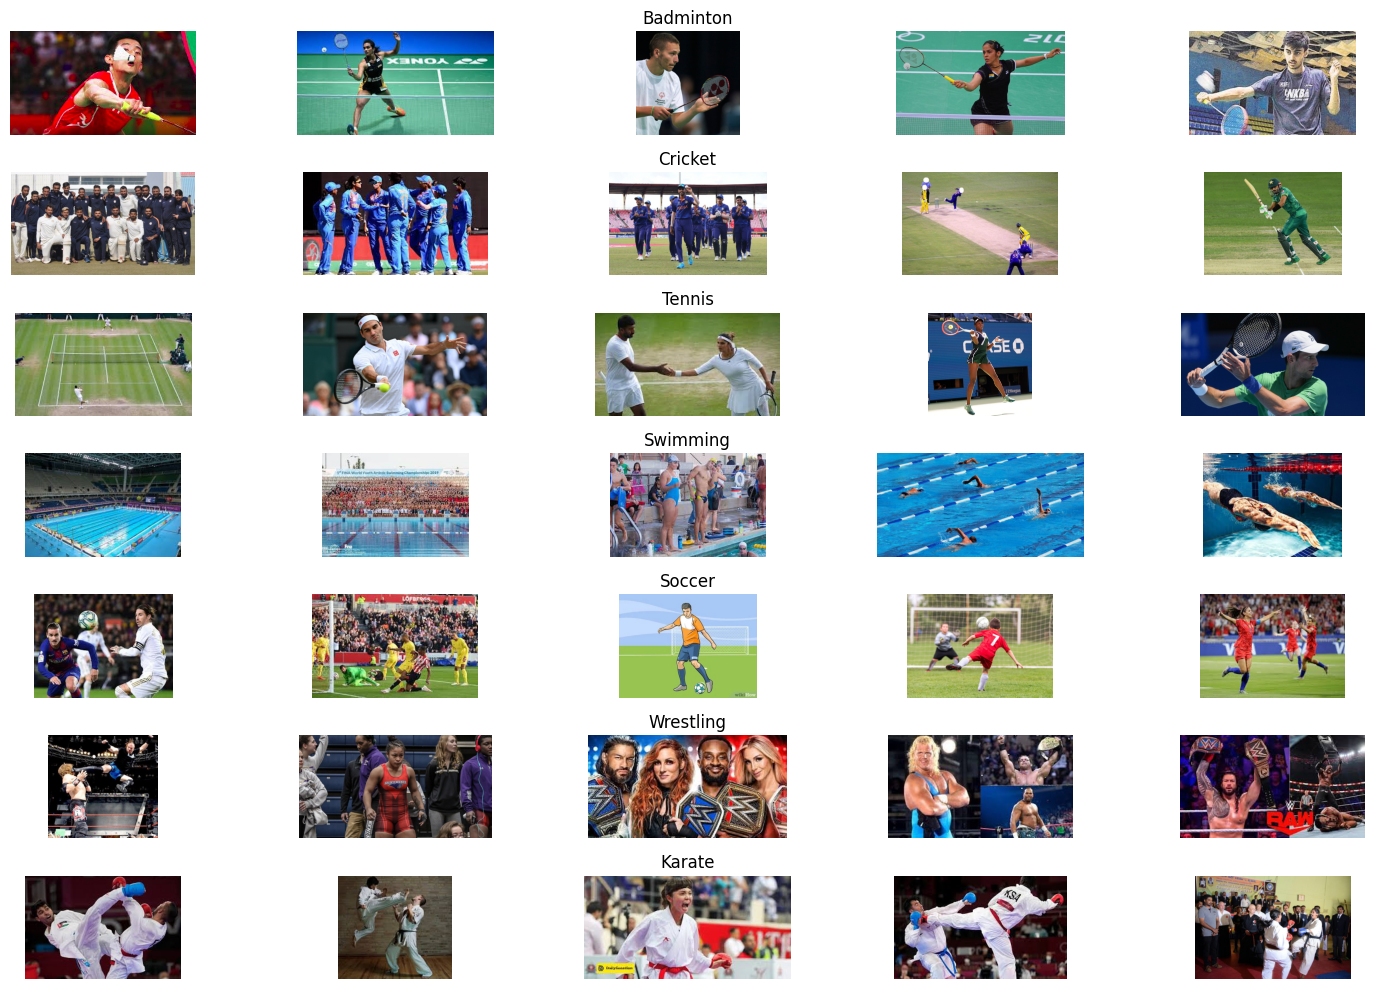

In [10]:

classes = train_df['label'].unique()
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    sample_imgs = train_df[train_df['label'] == cls].sample(5)['image_ID'].values
    for j, img_id in enumerate(sample_imgs):
        img_path = os.path.join(IMG_DIR, img_id)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), 5, i*5 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 2:
            plt.title(cls)

plt.tight_layout()
plt.show()


100%|██████████| 8227/8227 [00:30<00:00, 271.95it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


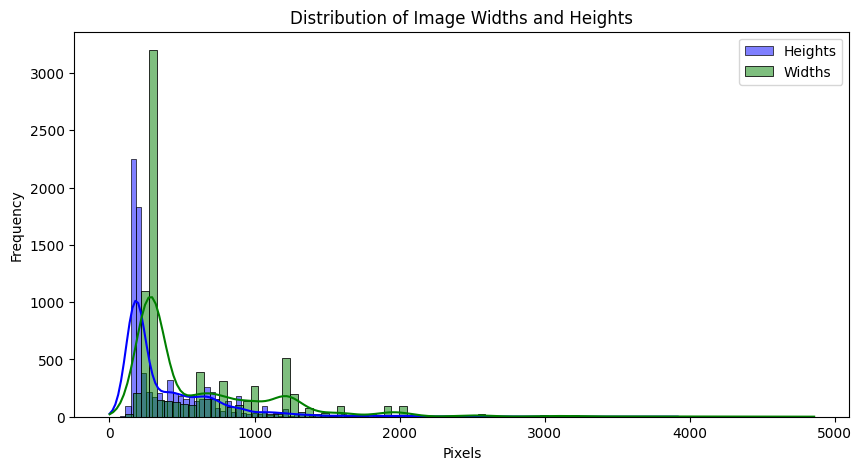

In [11]:

widths = []
heights = []

for img_id in tqdm(train_df['image_ID']):
    img_path = os.path.join(IMG_DIR, img_id)
    img = cv2.imread(img_path)
    if img is not None:
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)

plt.figure(figsize=(10,5))
sns.histplot(heights, kde=True, color='blue', label='Heights')
sns.histplot(widths, kde=True, color='green', label='Widths')
plt.legend()
plt.title("Distribution of Image Widths and Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()


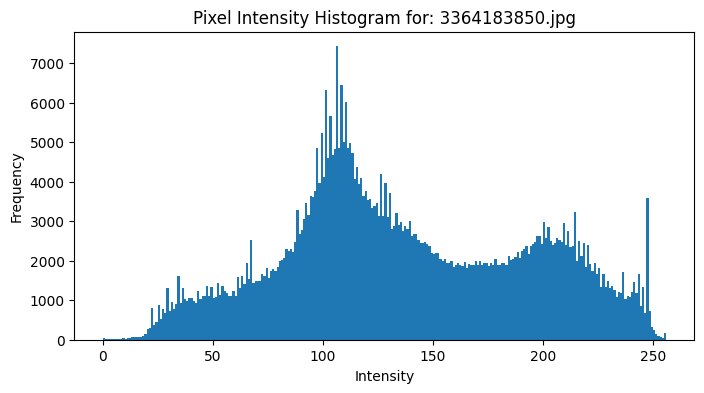

In [12]:
sample_img_id = train_df.sample(1)['image_ID'].values[0]
gray = cv2.imread(IMG_DIR+ '/'+ sample_img_id, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 4))
plt.hist(gray.ravel(), bins=256, range=[0, 256])
plt.title(f"Pixel Intensity Histogram for: {sample_img_id}")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


Generating augmented images...


100%|██████████| 8225/8225 [02:29<00:00, 54.99it/s]


Original dataset: 8225, After augmentation: 16450


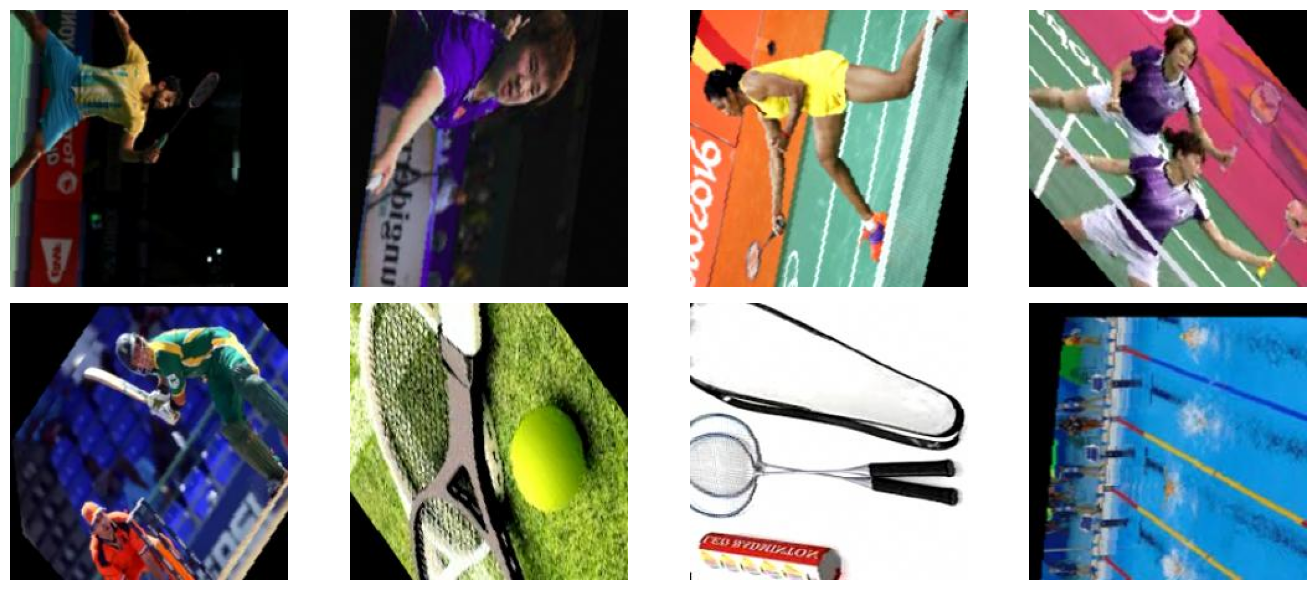

In [13]:

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Paths
ORIG_IMG_DIR = "/kaggle/input/sports-image-classification/dataset/train"
AUG_IMG_DIR = "/kaggle/working/augmented_images"
os.makedirs(AUG_IMG_DIR, exist_ok=True)

# Label mapping
label_to_idx = {label: idx for idx, label in enumerate(train_df_cleaned['label'].unique())}

# Custom noise function
def add_noise(image, noise_factor=0.1):
    image = np.array(image)
    noise = np.random.normal(0, noise_factor, image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    return Image.fromarray(noisy_image.astype(np.uint8))

# Data augmentation pipeline
augment_transform = transforms.Compose([
    # Rotation: Randomly rotate the image by 90 or 180 degrees
    transforms.Lambda(lambda x: x.rotate(random.choice([90, 45,65,180]))),
    
    # Translation: Randomly shift the image horizontally or vertically (10%)
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    
    # Scaling: Random crop with scale between 80% to 130%
    transforms.RandomResizedCrop(224, scale=(0.8, 1.3)),
    
    # Flipping: Horizontal and vertical flips
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    
    # Shearing: Apply affine shear of up to 10 degrees
    transforms.RandomAffine(0, shear=10),
    
    # Zooming: Adjust crop scale between 70% to 100%
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    
    # Brightness and contrast adjustment
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    
    # Add Gaussian noise
    transforms.Lambda(lambda x: add_noise(x, noise_factor=0.1)),
])

# Create augmented images and DataFrame
augmented_data = []

print("Generating augmented images...")
for i, row in tqdm(train_df_cleaned.iterrows(), total=len(train_df_cleaned)):
    orig_path = os.path.join(ORIG_IMG_DIR, row['image_ID'])
    try:
        image = Image.open(orig_path).convert('RGB')
        for j in range(1):  # Generate 1 augmentation per image (change to more if needed)
            aug_image = augment_transform(image)
            aug_filename = f"aug_{i}_{j}.jpg"
            aug_path = os.path.join(AUG_IMG_DIR, aug_filename)
            aug_image.save(aug_path)

            augmented_data.append({
                'image_ID': aug_filename,
                'label': row['label']
            })
    except:
        continue

# Create a DataFrame from the augmented images
augmented_df = pd.DataFrame(augmented_data)

# Combine with original data
combined_df = pd.concat([train_df_cleaned, augmented_df], ignore_index=True)
print(f"Original dataset: {len(train_df_cleaned)}, After augmentation: {len(combined_df)}")

# You can save this combined dataframe if needed
combined_df.to_csv("train_with_augmented.csv", index=False)

# Update IMG_DIR to point to combined original + augmented image folder
# We'll use both folders by pointing to a merged folder structure
FINAL_IMG_DIR = "/kaggle/working/combined_images"
os.makedirs(FINAL_IMG_DIR, exist_ok=True)

# Copy original images to combined folder (symbolic for Kaggle runtime)
for i, row in train_df_cleaned.iterrows():
    src = os.path.join(ORIG_IMG_DIR, row['image_ID'])
    dst = os.path.join(FINAL_IMG_DIR, row['image_ID'])
    if not os.path.exists(dst):
        os.system(f"cp '{src}' '{dst}'")

# Move augmented images
for i, row in augmented_df.iterrows():
    src = os.path.join(AUG_IMG_DIR, row['image_ID'])
    dst = os.path.join(FINAL_IMG_DIR, row['image_ID'])
    if not os.path.exists(dst):
        os.system(f"cp '{src}' '{dst}'")

# Function to plot augmented images
def plot_augmented_images(img_paths, n_images=8):
    """ Display a batch of augmented images """
    plt.figure(figsize=(14, 6))
    for i in range(n_images):
        img_path = img_paths[i]
        image = Image.open(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot sample augmented images
augmented_img_paths = [os.path.join(AUG_IMG_DIR, row['image_ID']) for i, row in augmented_df.iterrows()]
plot_augmented_images(augmented_img_paths, n_images=8)


In [14]:

# First split into 80% train and 20% temp (val + test)
train_df, temp_df = train_test_split(
    combined_df, 
    test_size=0.2, 
    stratify=combined_df['label'], 
    random_state=42
)

# Split the 20% temp into 10% val and 10% test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)

# Check sizes
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

# Optionally save them
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)


Train set: 13160
Validation set: 1645
Test set: 1645


In [15]:

# Conv block with optional bottleneck and SE block
def conv_block(x, filters, kernel_size=3, strides=1, use_se=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    if use_se:
        # Squeeze-and-Excitation block
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(filters // 8, activation='relu')(se)
        se = layers.Dense(filters, activation='sigmoid')(se)
        se = layers.Reshape((1, 1, filters))(se)
        x = layers.multiply([x, se])

    return x

In [16]:

def train_model(
    train_df,
    val_df,
    final_img_dir,
    input_shape=(224, 224, 3),
    num_classes=7,
    batch_size=32,
    num_conv_blocks=6,
    dropout_rate=0.5,
    optimizer_name='adam',
    weight_decay=0.001,
    initial_lr=1e-4,
    lr_scheduler= True,
    epochs=30
):

    K.clear_session()

    # Dataset preparation
    def prepare_datasets(train_df, val_df, img_dir, img_size=(224, 224), batch_size=32):
        label_encoder = LabelEncoder()
        all_labels = pd.concat([train_df['label'], val_df['label']])
        label_encoder.fit(all_labels)

        train_df['encoded_label'] = label_encoder.transform(train_df['label'])
        val_df['encoded_label'] = label_encoder.transform(val_df['label'])

        def load_image(image_id, label):
            image_path = tf.strings.join([img_dir, image_id], separator=os.sep)
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, img_size)
            image = image / 255.0
            return image, label

        train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_ID'].values, train_df['encoded_label'].values))
        val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_ID'].values, val_df['encoded_label'].values))

        train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_ds, val_ds
        
        # CNN architecture
    def variable_cnn(input_shape, num_classes, num_blocks, dropout_rate, weight_decay):
        inputs = tf.keras.Input(shape=input_shape)
        x = inputs
        filters = 32
        for _ in range(num_blocks):
            x = conv_block(x, filters, use_se=True)
            x = conv_block(x, filters, use_se=True)
            x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
            filters *= 2
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu',
                                  kernel_regularizer=regularizers.l2(weight_decay))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)

    # Optimizer + LR scheduler
    def compile_model(model, optimizer_name, initial_lr, lr_scheduler):
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
        elif optimizer_name == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=initial_lr, momentum=0.9)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        if lr_scheduler == 'exponential':
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr, decay_steps=1000, decay_rate=0.9, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        elif lr_scheduler == 'step':
            lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries=[1000, 2000], values=[initial_lr, initial_lr * 0.5, initial_lr * 0.1])
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        elif lr_scheduler == 'cosine':
            lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=initial_lr, decay_steps=3000, alpha=0.1)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    # Training loop
    def train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, weight_decay, lr_scheduler):
        callbacks = [
            ModelCheckpoint(filepath=f'/kaggle/working/best_model_one.keras',
                            monitor='val_loss', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
        ]
        if lr_scheduler is True:
            callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6))

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history

    # Prepare data
    train_ds, val_ds = prepare_datasets(train_df, val_df, final_img_dir, img_size=input_shape[:2], batch_size=batch_size)

    # Handle multiple weight decays
    if isinstance(weight_decay, list):
        results = {}
        for wd in weight_decay:
            model = variable_cnn(input_shape, num_classes, num_conv_blocks, dropout_rate, wd)
            model = compile_model(model, optimizer_name, initial_lr, lr_scheduler)
            history = train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, wd, lr_scheduler)
            results[wd] = history
        return results

    # Single weight decay
    model = variable_cnn(input_shape, num_classes, num_conv_blocks, dropout_rate, weight_decay)
    model = compile_model(model, optimizer_name, initial_lr, lr_scheduler)
    history = train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, weight_decay, lr_scheduler)

    return model, history






In [17]:
results = {}

# 1. Batch Size
for batch_size in [16, 32, 64]:
    print(f"\n Training with batch_size={batch_size}")
    model, history = train_model(
        train_df=train_df,
        val_df=val_df,
        final_img_dir=FINAL_IMG_DIR,
        batch_size=batch_size
    )
    model.save(f"/kaggle/working/model_batchsize_{batch_size}.h5")
    results[f'batch_size_{batch_size}'] = history.history

# 2. Number of Conv Blocks
for num_blocks in [4, 6]:
    print(f"\n Training with num_conv_blocks={num_blocks}")
    model, history = train_model(
        train_df=train_df,
        val_df=val_df,
        final_img_dir=FINAL_IMG_DIR,
        num_conv_blocks=num_blocks
    )
    model.save(f"/kaggle/working/model_numblocks_{num_blocks}.h5")
    results[f'num_conv_blocks_{num_blocks}'] = history.history


 Training with batch_size=16


I0000 00:00:1747029743.431335      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30


I0000 00:00:1747029765.460922   33003 service.cc:148] XLA service 0x7c206c003bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747029765.461929   33003 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747029767.359371   33003 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/823 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - accuracy: 0.1406 - loss: 4.5114   

I0000 00:00:1747029782.634700   33003 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


823/823 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4491 - loss: 3.7669
Epoch 1: val_loss improved from inf to 3.02320, saving model to /kaggle/working/best_model_one.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 112s 91ms/step - accuracy: 0.4492 - loss: 3.7666 - val_accuracy: 0.6547 - val_loss: 3.0232 - learning_rate: 1.0000e-04
Epoch 2/30
822/823 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6011 - loss: 3.0732
Epoch 2: val_loss improved from 3.02320 to 2.80387, saving model to /kaggle/working/best_model_one.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 56s 67ms/step - accuracy: 0.6011 - loss: 3.0729 - val_accuracy: 0.5976 - val_loss: 2.8039 - learning_rate: 1.0000e-04
Epoch 3/30
822/823 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6494 - loss: 2.5955
Epoch 3: val_loss improved from 2.80387 to 2.24222, saving model to /kaggle/working/best_model_one.keras
823/823 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.6494 - loss: 2.5952 - val_accuracy: 0.6845 - val_loss: 2.2422 - learning_rate: 1.0000e-

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4835 - loss: 3.7426
Epoch 1: val_loss improved from inf to 4.14527, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 104s 151ms/step - accuracy: 0.4836 - loss: 3.7421 - val_accuracy: 0.2456 - val_loss: 4.1453 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6316 - loss: 3.1655
Epoch 2: val_loss improved from 4.14527 to 3.17962, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 48s 113ms/step - accuracy: 0.6316 - loss: 3.1651 - val_accuracy: 0.5909 - val_loss: 3.1796 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6678 - loss: 2.8441
Epoch 3: val_loss improved from 3.17962 to 3.00001, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 48s 113ms/step - accuracy: 0.6679 - loss: 2.8437 - val_accuracy: 0.6249 - val_loss: 3.0000 - learni

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30


2025-05-12 06:56:01.305042: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,224,224]{3,2,1,0}, f32[64,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-12 06:56:01.487976: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.183083322s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,224,224]{3,2,1,0}, f32[64,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"act

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4884 - loss: 3.7296
Epoch 1: val_loss improved from inf to 4.48839, saving model to /kaggle/working/best_model_one.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 124s 363ms/step - accuracy: 0.4887 - loss: 3.7286 - val_accuracy: 0.1757 - val_loss: 4.4884 - learning_rate: 1.0000e-04
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6547 - loss: 3.1962
Epoch 2: val_loss improved from 4.48839 to 3.87769, saving model to /kaggle/working/best_model_one.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.6547 - loss: 3.1959 - val_accuracy: 0.2881 - val_loss: 3.8777 - learning_rate: 1.0000e-04
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7033 - loss: 2.9429
Epoch 3: val_loss improved from 3.87769 to 3.24654, saving model to /kaggle/working/best_model_one.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.7033 - loss: 2.9427 - val_accuracy: 0.5787 - val_loss: 3.2465 - learning_rate: 1.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4602 - loss: 2.1527
Epoch 1: val_loss improved from inf to 2.41882, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.4604 - loss: 2.1522 - val_accuracy: 0.2924 - val_loss: 2.4188 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6240 - loss: 1.7134
Epoch 2: val_loss improved from 2.41882 to 1.58109, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.6240 - loss: 1.7132 - val_accuracy: 0.6638 - val_loss: 1.5811 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6639 - loss: 1.5756
Epoch 3: val_loss improved from 1.58109 to 1.53667, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.6639 - loss: 1.5755 - val_accuracy: 0.6790 - val_loss: 1.5367 - learning_rat

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4940 - loss: 3.6898
Epoch 1: val_loss improved from inf to 4.14376, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 90s 147ms/step - accuracy: 0.4941 - loss: 3.6893 - val_accuracy: 0.2492 - val_loss: 4.1438 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6369 - loss: 3.1431
Epoch 2: val_loss improved from 4.14376 to 2.92444, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6369 - loss: 3.1428 - val_accuracy: 0.6541 - val_loss: 2.9244 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6820 - loss: 2.7944
Epoch 3: val_loss improved from 2.92444 to 2.67123, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6821 - loss: 2.7941 - val_accuracy: 0.6687 - val_loss: 2.6712 - learnin

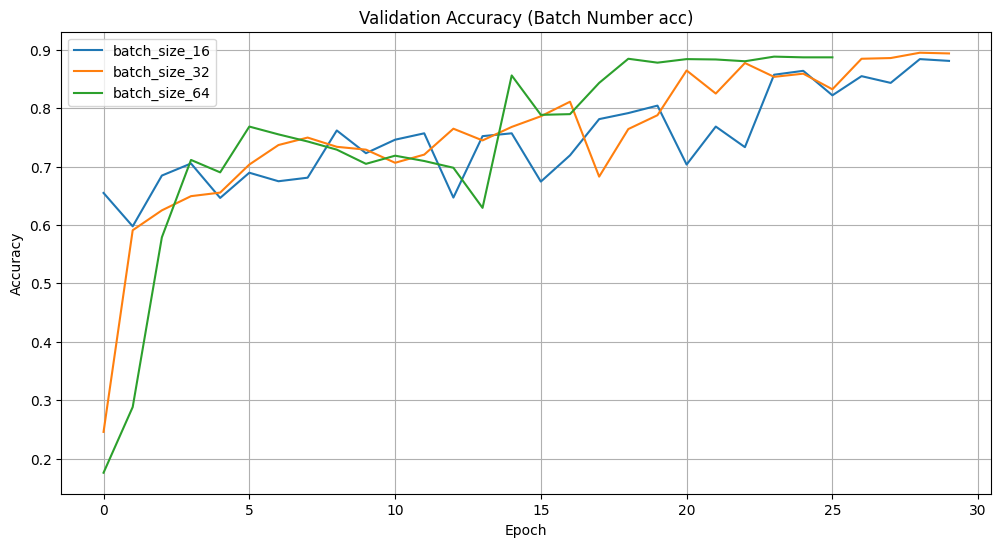

In [23]:

# Plot Batch number val_acc

plt.figure(figsize=(12, 6))

# Grab first 3 keys
first_three_keys = list(results.keys())[:3]

for key in first_three_keys:
    plt.plot(results[key]['val_accuracy'], label=key)

plt.title('Validation Accuracy (Batch Number acc)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


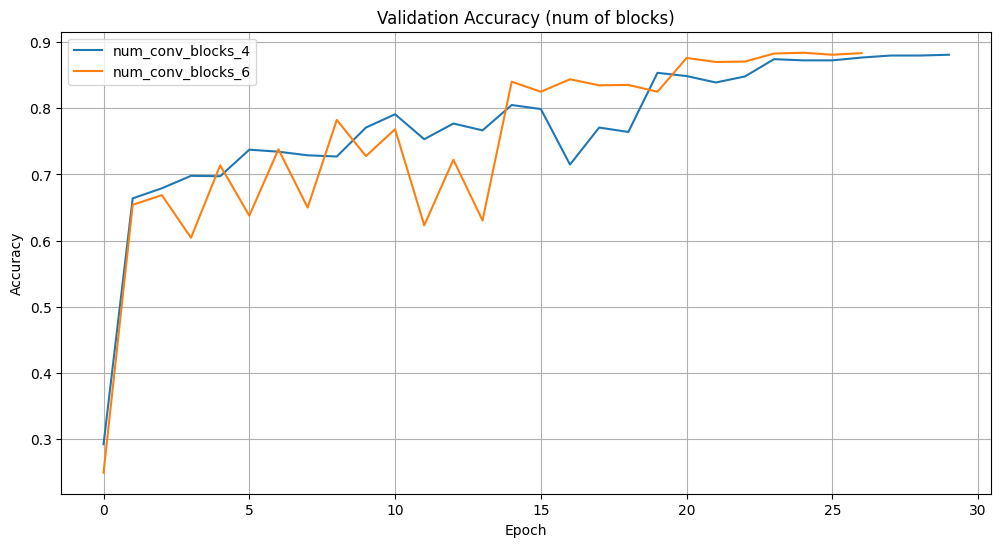

In [24]:
# plot num of blocks

plt.figure(figsize=(12, 6))

# Get the remaining keys (starting from index 3)
remaining_keys = list(results.keys())[3:]

for key in remaining_keys:
    plt.plot(results[key]['val_accuracy'], label=key)

plt.title('Validation Accuracy (num of blocks)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# config summary

summary_data = []

for key, value in results.items():
    best_val_acc = max(value['val_accuracy'])
    summary_data.append({
        'Configuration': key,
        'Best Val Accuracy': round(best_val_acc, 4),
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Best Val Accuracy', ascending=False).reset_index(drop=True)
print(summary_df)


       Configuration  Best Val Accuracy
0      batch_size_32             0.8948
1      batch_size_64             0.8881
2      batch_size_16             0.8839
3  num_conv_blocks_6             0.8839
4  num_conv_blocks_4             0.8809


In [26]:
def prepare_test_dataset(test_df, img_dir, img_size=(224, 224), batch_size=32, label_encoder=None):
    if label_encoder is None:
        raise ValueError("You must pass the same LabelEncoder used in training.")

    test_df = test_df.copy()
    test_df['encoded_label'] = label_encoder.transform(test_df['label'])

    def load_image(image_id, label):
        image_path = tf.strings.join([img_dir, image_id], separator=os.sep)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = image / 255.0
        return image, label

    test_ds = tf.data.Dataset.from_tensor_slices((test_df['image_ID'].values, test_df['encoded_label'].values))
    test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return test_ds

def model_evaluation(model, test_df, final_img_dir, input_shape, 
label_encoder, history=None, batch_size=32):
    # Prepare test dataset
    test_ds = prepare_test_dataset(
        test_df=test_df,
        img_dir=final_img_dir,
        img_size=input_shape[:2],
        batch_size=batch_size,
        label_encoder=label_encoder
    )

# Evaluate model
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Plot training/validation accuracy if history is provided
    if history:
        acc = history.history.get('accuracy')
        val_acc = history.history.get('val_accuracy')
        plt.plot(acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    return test_acc

In [28]:
label_encoder = LabelEncoder()
all_labels = pd.concat([train_df['label'], val_df['label']])
label_encoder.fit(all_labels)

LabelEncoder()

In [29]:
test_results = {}

# Evaluate models saved during batch size tuning
for batch_size in [16, 32, 64]:
    model_path = f"/kaggle/working/model_batchsize_{batch_size}.h5"
    model = load_model(model_path)

    print(f"\n Evaluating model with batch_size={batch_size}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=None
    )
    test_results[f'batch_size_{batch_size}'] = test_acc

# Evaluate models saved during number of convolutional blocks tuning
for num_blocks in [4, 6]:
    model_path = f"/kaggle/working/model_numblocks_{num_blocks}.h5"
    model = load_model(model_path)

    print(f"\n Evaluating model with num_conv_blocks={num_blocks}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=None
    )
    test_results[f'num_conv_blocks_{num_blocks}'] = test_acc



 Evaluating model with batch_size=16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9056 - loss: 0.6955
Test Accuracy: 0.9003
Test Loss: 0.7086

 Evaluating model with batch_size=32
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8886 - loss: 0.9142
Test Accuracy: 0.8845
Test Loss: 0.9228

 Evaluating model with batch_size=64
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9084 - loss: 1.2383
Test Accuracy: 0.8948
Test Loss: 1.2816

 Evaluating model with num_conv_blocks=4
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8843 - loss: 0.6702
Test Accuracy: 0.8833
Test Loss: 0.6747

 Evaluating model with num_conv_blocks=6
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8793 - loss: 0.9799
Test Accuracy: 0.8778
Test Loss: 0.9834


In [ ]:
test_results = {}

# Evaluate models saved during batch size tuning
for batch_size in [16, 32, 64]:
    model_path = f"/kaggle/working/model_batchsize_{batch_size}.h5"
    model = load_model(model_path)

    print(f"\n Evaluating model with batch_size={batch_size}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=history
    )
    test_results[f'batch_size_{batch_size}'] = test_acc

# Evaluate models saved during number of convolutional blocks tuning
for num_blocks in [4, 6]:
    model_path = f"/kaggle/working/model_numblocks_{num_blocks}.h5"
    model = load_model(model_path)

    print(f"\n Evaluating model with num_conv_blocks={num_blocks}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=history
    )
    test_results[f'num_conv_blocks_{num_blocks}'] = test_acc
